<h2>1.Introduction</h2>

<b>One of the most important problem in our days is covid-19 and his backwash. Many places were closed recently cause it. There were and are huge finance losses and at the moment situation is not adjusted. I decided analyze places for current moment. I want to try to understand impact what virus got brought. I want to get city districts which still have some problems in the form of closed cafe, restaurants and similar places. I want to show what kind of business still have difficulties. Business owners will be able to take note of this.

For my idea I decided to pick San Francisco because this city was badly hit by the virus.</b>

<h2>2.Data description</h2>

<b>First, I will have to use Foursquare API[1] for getting venues per district (It was a prerequisite when setting the problem). When I get list of venues I want to pars web-maps (as Google maps) for getting current business status of venues. Also, I will have to limit quantity of API-requests.

I will use public files with coordinates of city and districts which easy found in web.</b>

<h2> 3.Methodology </h2>

In [4]:
import numpy as np 
import pandas as pd 
import json 
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

<b>Lets create first data frame with San Francisko boroughs
I got data with main San Francisco districts and found coordinates for everyone. Total main list with 21 borough looks like</b>

In [5]:
df_nh = pd.read_html('http://www.healthysf.org/bdi/outcomes/zipmap.htm') # get data from web

In [6]:
df_nh = df_nh[3] # get 6 tables, this neccessary table

In [7]:
df_nh 

,0,1,2
0,Zip Code,Neighborhood,Population (Census 2000)
1,94102,Hayes Valley/Tenderloin/North of Market,28991
2,94103,South of Market,23016
3,94107,Potrero Hill,17368
4,94108,Chinatown,13716
5,94109,Polk/Russian Hill (Nob Hill),56322
6,94110,Inner Mission/Bernal Heights,74633
7,94112,Ingelside-Excelsior/Crocker-Amazon,73104
8,94114,Castro/Noe Valley,30574
9,94115,Western Addition/Japantown,33115


In [8]:
columns = df_nh.loc[0,:].tolist() # get list of columns

In [9]:
df_nh.shape

(23, 3)

In [10]:
df_nh.drop([0,22], axis=0, inplace=True) # remove 1st and last rows

In [11]:
df_nh.columns = columns


In [12]:
df_nh.reset_index(drop=True) # reindex because we droped rows

,Zip Code,Neighborhood,Population (Census 2000)
0,94102,Hayes Valley/Tenderloin/North of Market,28991
1,94103,South of Market,23016
2,94107,Potrero Hill,17368
3,94108,Chinatown,13716
4,94109,Polk/Russian Hill (Nob Hill),56322
5,94110,Inner Mission/Bernal Heights,74633
6,94112,Ingelside-Excelsior/Crocker-Amazon,73104
7,94114,Castro/Noe Valley,30574
8,94115,Western Addition/Japantown,33115
9,94116,Parkside/Forest Hill,42958


<b>Download extra file with ZIP-codes and coordinates. It need for adding latitude and longitude to first data frame</b>

In [13]:
df_allzip = pd.read_csv('/home/cat/Downloads/uszips.csv') # get all zips with coordinates, I downloaded it from web

In [14]:
df_allzip


,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18004,-66.75218,Adjuntas,PR,Puerto Rico,True,NaN,17242,111.4,72001,Adjuntas,"{'72001':99.43,'72141':0.57}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36073,-67.17517,Aguada,PR,Puerto Rico,True,NaN,38442,523.5,72003,Aguada,{'72003':100},Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45439,-67.12202,Aguadilla,PR,Puerto Rico,True,NaN,48814,667.9,72005,Aguadilla,{'72005':100},Aguadilla,72005,False,False,America/Puerto_Rico
3,606,18.16724,-66.93828,Maricao,PR,Puerto Rico,True,NaN,6437,60.4,72093,Maricao,"{'72093':94.88,'72121':1.35,'72153':3.78}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29032,-67.12243,Anasco,PR,Puerto Rico,True,NaN,27073,312.0,72011,Añasco,"{'72003':0.55,'72011':99.45}",Añasco|Aguada,72011|72003,False,False,America/Puerto_Rico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33094,99923,55.97796,-130.03671,Hyder,AK,Alaska,True,NaN,15,2.1,2198,Prince of Wales-Hyder,{'02198':100},Prince of Wales-Hyder,02198,False,False,America/Sitka
33095,99925,55.55767,-132.97627,Klawock,AK,Alaska,True,NaN,927,5.7,2198,Prince of Wales-Hyder,{'02198':100},Prince of Wales-Hyder,02198,False,False,America/Sitka
33096,99926,55.12617,-131.48928,Metlakatla,AK,Alaska,True,NaN,1635,4.2,2198,Prince of Wales-Hyder,{'02198':100},Prince of Wales-Hyder,02198,False,False,America/Metlakatla
33097,99927,56.25100,-133.37571,Point Baker,AK,Alaska,True,NaN,38,0.2,2198,Prince of Wales-Hyder,{'02198':100},Prince of Wales-Hyder,02198,False,False,America/Sitka


In [15]:
df_nh['Latitude'] = ''   # insert empty columns
df_nh['Longitude'] = ''

In [16]:
for data in df_nh.index:   
    pc = df_nh.loc[data, 'Zip Code'] # take zip from main df
    latitude = df_allzip[df_allzip['zip']==int(pc)].lat.values[0] # search and fill lat and long
    longitude = df_allzip[df_allzip['zip']==int(pc)].lng.values[0]
    df_nh.loc[data, 'Latitude'] = latitude
    df_nh.loc[data, 'Longitude'] = longitude

<b>Final df looks like</b>

In [17]:
df_nh # df with zips and coordinates

,Zip Code,Neighborhood,Population (Census 2000),Latitude,Longitude
1,94102,Hayes Valley/Tenderloin/North of Market,28991,37.7797,-122.419
2,94103,South of Market,23016,37.7732,-122.411
3,94107,Potrero Hill,17368,37.7664,-122.395
4,94108,Chinatown,13716,37.792,-122.409
5,94109,Polk/Russian Hill (Nob Hill),56322,37.7952,-122.422
6,94110,Inner Mission/Bernal Heights,74633,37.75,-122.415
7,94112,Ingelside-Excelsior/Crocker-Amazon,73104,37.7203,-122.443
8,94114,Castro/Noe Valley,30574,37.758,-122.435
9,94115,Western Addition/Japantown,33115,37.786,-122.437
10,94116,Parkside/Forest Hill,42958,37.7446,-122.486


***************************************************************************************

<b>Next, I want to get San Francisko map with center of each district looks like cirkles. I use Folium library. </b>

In [18]:
address = 'San Francisco, USA'  
geolocator = Nominatim(user_agent="ny_explorer")   # get SF location for foliun in next step
location = geolocator.geocode(address)
latitude_sf = location.latitude
longitude_sf = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude_sf, longitude_sf))

The geograpical coordinate of San Francisco are 37.7790262, -122.4199061.


In [19]:
map_sf = folium.Map(location=[latitude_sf, longitude_sf], zoom_start=12)  # map SF

# add markers to map
for lat, lng, neighborhood in zip(df_nh['Latitude'], df_nh['Longitude'], df_nh['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)  
    
map_sf

<b>Now is the time for Foursquare API. 
I limited venue number in 100 and radius in 500 meter per borough. Thru API-requests I got names, category, coordinates, addresses for every venue.
I covered ID and Password</b>


In [20]:
CLIENT_ID = 'XXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius


In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):   # create function for creating df with necessary venue data
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  # venue name 
            v['venue']['location']['formattedAddress'], # adress
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'Venue Adress',            
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
sf_venues = getNearbyVenues(names=df_nh['Neighborhood'],
                                   latitudes=df_nh['Latitude'],
                                   longitudes=df_nh['Longitude']
                                  )    # get df with venues 

Hayes Valley/Tenderloin/North of Market
South of Market
Potrero Hill
Chinatown
Polk/Russian Hill (Nob Hill)
Inner Mission/Bernal Heights
Ingelside-Excelsior/Crocker-Amazon
Castro/Noe Valley
Western Addition/Japantown
Parkside/Forest Hill
Haight-Ashbury
Inner Richmond
Outer Richmond
Sunset
Marina
Bayview-Hunters Point
St. Francis Wood/Miraloma/West Portal
Twin Peaks-Glen Park
Lake Merced
North Beach/Chinatown
Visitacion Valley/Sunnydale


<b>This is data frame with all venues.There are 1820 rows in total</b>

In [23]:
sf_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Adress,Venue Latitude,Venue Longitude,Venue Category
0,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Louise M. Davies Symphony Hall,"[201 Van Ness Ave (btwn Grove & Hayes St), San...",37.777976,-122.420157,Concert Hall
1,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,War Memorial Opera House,"[301 Van Ness Ave (at Grove St), San Francisco...",37.778601,-122.420816,Opera House
2,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Herbst Theater,"[401 Van Ness Ave (at McAllister St), San Fran...",37.779548,-122.420953,Concert Hall
3,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,San Francisco Ballet,"[455 Franklin St (btw Fulton & Grove), San Fra...",37.778580,-122.420798,Dance Studio
4,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Asian Art Museum,"[200 Larkin St (at McAllister St), San Francis...",37.780178,-122.416505,Art Museum
...,...,...,...,...,...,...,...,...
1815,Visitacion Valley/Sunnydale,37.71938,-122.41180,Little Village,"[San Francisco, CA, United States]",37.712086,-122.415726,Liquor Store
1816,Visitacion Valley/Sunnydale,37.71938,-122.41180,Visitacion Valley Playground Baseball Field,"[700 Delta (Visitacion Ave), San Francisco, CA...",37.711423,-122.410775,Baseball Field
1817,Visitacion Valley/Sunnydale,37.71938,-122.41180,Philosopher's Way,"[McLaren Park, San Francisco, CA 94134, United...",37.720126,-122.422401,Art Gallery
1818,Visitacion Valley/Sunnydale,37.71938,-122.41180,MUNI Bus Stop - Visitacion Ave & Rutland St,"[San Francisco, CA, United States]",37.711335,-122.407566,Bus Stop


In [24]:
sf_venues.to_csv('sf_venues.csv') # save df

In [213]:
sf_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Adress,Venue Latitude,Venue Longitude,Venue Category
0,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Louise M. Davies Symphony Hall,"[201 Van Ness Ave (btwn Grove & Hayes St), San...",37.777976,-122.420157,Concert Hall
1,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,War Memorial Opera House,"[301 Van Ness Ave (at Grove St), San Francisco...",37.778601,-122.420816,Opera House
2,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Herbst Theater,"[401 Van Ness Ave (at McAllister St), San Fran...",37.779548,-122.420953,Concert Hall
3,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,San Francisco Ballet,"[455 Franklin St (btw Fulton & Grove), San Fra...",37.778580,-122.420798,Dance Studio
4,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Asian Art Museum,"[200 Larkin St (at McAllister St), San Francis...",37.780178,-122.416505,Art Museum
...,...,...,...,...,...,...,...,...
1815,Visitacion Valley/Sunnydale,37.71938,-122.41180,Little Village,"[San Francisco, CA, United States]",37.712086,-122.415726,Liquor Store
1816,Visitacion Valley/Sunnydale,37.71938,-122.41180,Visitacion Valley Playground Baseball Field,"[700 Delta (Visitacion Ave), San Francisco, CA...",37.711423,-122.410775,Baseball Field
1817,Visitacion Valley/Sunnydale,37.71938,-122.41180,Philosopher's Way,"[McLaren Park, San Francisco, CA 94134, United...",37.720126,-122.422401,Art Gallery
1818,Visitacion Valley/Sunnydale,37.71938,-122.41180,MUNI Bus Stop - Visitacion Ave & Rutland St,"[San Francisco, CA, United States]",37.711335,-122.407566,Bus Stop


<b>Create empty columns. I will write venue status inside it. </b>

In [215]:
sf_venues['Status']=''  # empty column

In [216]:
sf_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Adress,Venue Latitude,Venue Longitude,Venue Category,Status
0,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Louise M. Davies Symphony Hall,"[201 Van Ness Ave (btwn Grove & Hayes St), San...",37.777976,-122.420157,Concert Hall,
1,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,War Memorial Opera House,"[301 Van Ness Ave (at Grove St), San Francisco...",37.778601,-122.420816,Opera House,
2,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Herbst Theater,"[401 Van Ness Ave (at McAllister St), San Fran...",37.779548,-122.420953,Concert Hall,
3,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,San Francisco Ballet,"[455 Franklin St (btw Fulton & Grove), San Fra...",37.778580,-122.420798,Dance Studio,
4,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Asian Art Museum,"[200 Larkin St (at McAllister St), San Francis...",37.780178,-122.416505,Art Museum,
...,...,...,...,...,...,...,...,...,...
1815,Visitacion Valley/Sunnydale,37.71938,-122.41180,Little Village,"[San Francisco, CA, United States]",37.712086,-122.415726,Liquor Store,
1816,Visitacion Valley/Sunnydale,37.71938,-122.41180,Visitacion Valley Playground Baseball Field,"[700 Delta (Visitacion Ave), San Francisco, CA...",37.711423,-122.410775,Baseball Field,
1817,Visitacion Valley/Sunnydale,37.71938,-122.41180,Philosopher's Way,"[McLaren Park, San Francisco, CA 94134, United...",37.720126,-122.422401,Art Gallery,
1818,Visitacion Valley/Sunnydale,37.71938,-122.41180,MUNI Bus Stop - Visitacion Ave & Rutland St,"[San Francisco, CA, United States]",37.711335,-122.407566,Bus Stop,


<b>Next I have to check business status for every place. I noticed Google Maps have special field for every merchant if it temporary closed. With Selenium library I went thru all my list of venue and got status. I used name and address for creating search request on Google and just checked for field presents. For every row I wrote status in data frame.
I printed some text just for observation. I did not used it<b>

In [225]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import regex
driver = webdriver.Firefox()
driver.get("https://www.google.com/maps/")
for row in sf_venues.index:
    
    va = str(sf_venues.loc[row,'Venue Adress']) # take adress from df
    try: # if there is adress
        va_f = regex.findall(r'[\d+]+[\s\w+]+', va) # take only part of adress till '(', only nessecary part
        link = str(sf_venues.loc[row,'Venue']) + ' ' + va_f[0] # create link for google maps
    except:# if there is no adress
        print('There is no adress')
        link = ''
    

    search = driver.find_element_by_xpath("//*[@id='searchboxinput']") # find search field
    time.sleep(1)
    search.clear() # clear field
    search.send_keys(link) # write our link to fild Search
    search.send_keys(Keys.ENTER) # press ENTER
    time.sleep(2) # delay
    try:   # if element "temporary clodsed" exist we can find it and write data "Closed "to df
        tc = driver.find_element_by_xpath("/html/body/jsl/div[3]/div[9]/div[8]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[3]/span/span[1]/span")
        sf_venues.loc[row,'Status'] = 'Closed'
        print(link, 'Closed')
    except: # if element doesnt exist 
        sf_venues.loc[row,'Status'] = 'Open'
    


War Memorial Opera House 301 Van Ness Ave  Closed
Herbst Theater 401 Van Ness Ave  Closed
Asian Art Museum 200 Larkin St  Closed
Main Stage Of Davies Symphony Hall 94102 Closed
SFJazz Center 201 Franklin St  Closed
War Memorial Veterans Building 401 Van Ness Ave  Closed
Welcome Stranger 460 Gough St Closed
Fig & Thistle Wine Bar 313 Ivy St  Closed
New Conservatory Theatre Center 25 Van Ness Ave  Closed
Bi-Rite Cafe 52 Grove Street  Closed
Absinthe Brasserie & Bar 398 Hayes St  Closed
The Strand 1127 Market St  Closed
Fitness SF 1 10th St  Closed
Chantal Guillon Macarons & Tea 437 Hayes St  Closed
Onsen 466 Eddy St Closed
Opera Plaza Cinema 601 Van Ness Ave  Closed
Proxy SF 432 Octavia St  Closed
Soundbox 300 Franklin St Closed
Great American Music Hall 859 Ofarrell St  Closed
Nightbird 330 Gough St  Closed
Yoga Tree Hayes 519 Hayes St Closed
STUDIOMIX 1000 Van Ness Ave Fl 3  Closed
Mr. S Leather & Mr. S Locker Room 385 8th St  Closed
Lennon Rehearsal Studios 271 Dore St  Closed
MUJI 無印

There is no adress
There is no adress
There is no adress
Vin Debut 9 West Portal Ave Closed
There is no adress
Thriveability 300 Closed
Pure Barre West Portal 162 West Portal Ave  Closed
Ambassador Toys 186 West Portal Ave Closed
CinéArts 85 West Portal Ave  Closed
Que Syrah 230 West Portal Ave Closed
The Dubliner 328 West Portal Ave Closed
There is no adress
There is no adress
There is no adress
Dimitra's Facial & Body Therapy 330 West Portal Ave Closed
Edible Arrangements 312 West Portal Ave Closed
There is no adress
Firefly Restaurant 4288 24th St  Closed
Portola Nail Salon 619 Portola Dr Closed
Yoga Mayu 4159 24th St  Closed
Charlie's Corner 4102 24th St  Closed
Noe Valley Branch Library 451 Jersey St  Closed
There is no adress
There is no adress
There is no adress
There is no adress
Matcha Cafe Maiko 3251 20th Ave Ste 250K Closed
There is no adress
Peet's Coffee & Tea 1630 Holloway Ave Closed
Jamba Juice 3251 20th Ave Closed
Tokyo Express 3251 20th Ave Closed
Stonestown Galleria 3

<b>I decided save df to csv immediatly, because I spent a lot of time for parsing.</b>

In [227]:
sf_venues.to_csv('sf_venues2.csv') 

<b>I came bake after pause. I gave new name for ald df for comfor understanding.</b>

In [246]:
sf_venues2 = pd.read_csv('sf_venues2.csv')

In [247]:
sf_venues2

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Adress,Venue Latitude,Venue Longitude,Venue Category,Status
0,0,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Louise M. Davies Symphony Hall,"['201 Van Ness Ave (btwn Grove & Hayes St)', '...",37.777976,-122.420157,Concert Hall,Open
1,1,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,War Memorial Opera House,"['301 Van Ness Ave (at Grove St)', 'San Franci...",37.778601,-122.420816,Opera House,Closed
2,2,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Herbst Theater,"['401 Van Ness Ave (at McAllister St)', 'San F...",37.779548,-122.420953,Concert Hall,Closed
3,3,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,San Francisco Ballet,"['455 Franklin St (btw Fulton & Grove)', 'San ...",37.778580,-122.420798,Dance Studio,Open
4,4,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Asian Art Museum,"['200 Larkin St (at McAllister St)', 'San Fran...",37.780178,-122.416505,Art Museum,Closed
...,...,...,...,...,...,...,...,...,...,...
1815,1815,Visitacion Valley/Sunnydale,37.71938,-122.41180,Little Village,"['San Francisco, CA', 'United States']",37.712086,-122.415726,Liquor Store,Open
1816,1816,Visitacion Valley/Sunnydale,37.71938,-122.41180,Visitacion Valley Playground Baseball Field,"['700 Delta (Visitacion Ave)', 'San Francisco,...",37.711423,-122.410775,Baseball Field,Open
1817,1817,Visitacion Valley/Sunnydale,37.71938,-122.41180,Philosopher's Way,"['McLaren Park', 'San Francisco, CA 94134', 'U...",37.720126,-122.422401,Art Gallery,Open
1818,1818,Visitacion Valley/Sunnydale,37.71938,-122.41180,MUNI Bus Stop - Visitacion Ave & Rutland St,"['San Francisco, CA', 'United States']",37.711335,-122.407566,Bus Stop,Open


In [248]:
sf_venues2['Status'].value_counts() # count Opened and Closed venues

Open      1596
Closed     224
Name: Status, dtype: int64

<b>Define function for changing values in Status column. After make it.</b>

In [249]:
def encode(x):   # change values Status to int
     return 1 if x == 'Open' else 0
sf_venues2['Status'] = sf_venues2.Status.apply(encode)

<b>Changing categorical values to numerical and write if to new data frame. Special pandas function make it very easy. Look at new df. After it join Status column to new df</b>

In [251]:
sf_cat = pd.get_dummies(sf_venues2[['Venue Category']], prefix="", prefix_sep="") # categorical to numerical kind of venues


In [255]:
sf_cat

,Accessories Store,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1816,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1817,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [256]:
sf_cat['Status']=sf_venues2['Status'] # add column Status to new df

In [257]:
sf_cat

,Accessories Store,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit,Status
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1816,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1817,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<b>Split df to two new with different Status. I will explore it. After I drop column status because it more not necessary for this step </b>

In [313]:
sf_cat_open = sf_cat[sf_cat['Status'] == 1] # devide data to 2 df, later I created new 
sf_cat_close = sf_cat[sf_cat['Status'] == 0]

In [264]:
sf_cat_open.drop(columns=['Status'], axis=0, inplace=True)

/home/cat/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [266]:
sf_cat_close.drop(columns=['Status'], axis=0, inplace=True)

/home/cat/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<b>In this step I will work with only Opened venues. I will calculate values for all kind of venue and plot the histogramm</b>

In [267]:
sf_cat_open = sf_cat_open.T # transpose index and columns

In [294]:
sf_cat_open['sum'] = 0
sf_cat_open = sf_cat_open.astype('int32')

In [295]:

sf_cat_open.dtypes

0       int32
3       int32
5       int32
6       int32
7       int32
        ...  
1816    int32
1817    int32
1818    int32
1819    int32
sum     int32
Length: 1597, dtype: object

In [298]:
sf_cat_open['sum'] = sf_cat_open.sum(axis=1) # sum thru row and fill to new column

In [305]:
sf_cat_open_sort = sf_cat_open[sf_cat_open['sum']>10].sort_values('sum', ascending=False) # sorting for plotting


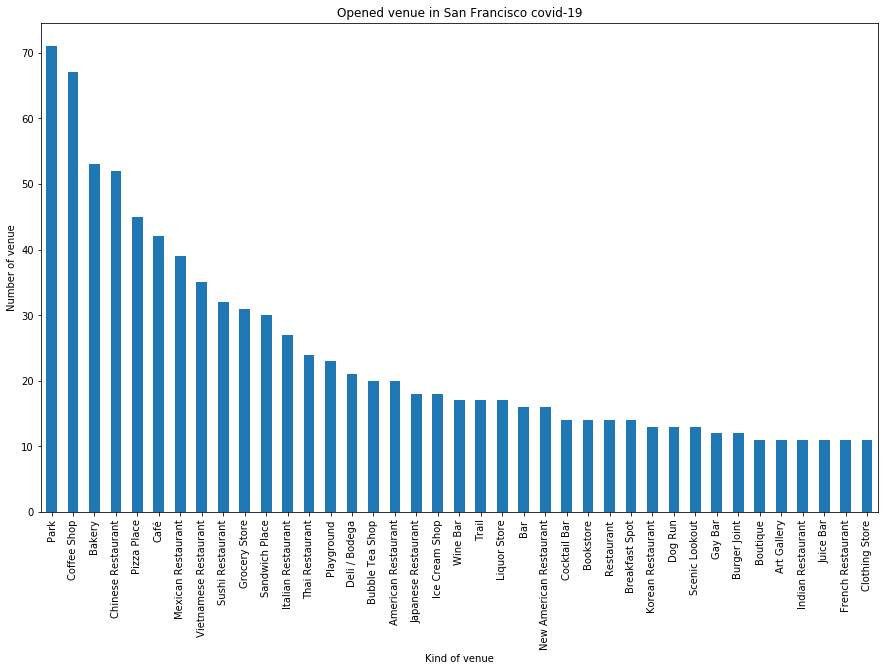

In [308]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

sf_cat_open_sort['sum'].plot(kind='bar', figsize=(15, 9))

plt.xlabel('Kind of venue') # add to x-label to the plot
plt.ylabel('Number of venue') # add y-label to the plot
plt.title('Opened venue in San Francisco covid-19') # add title to the plot

plt.show()

<b>Repeat previous step for Closed venues</b>

In [314]:
sf_cat_close = sf_cat_close.T # transpose index and columns
sf_cat_close = sf_cat_close.astype('int32')
sf_cat_close['sum'] = sf_cat_close.sum(axis=1)
sf_cat_close_sort = sf_cat_close[sf_cat_close['sum']>2].sort_values('sum', ascending=False)


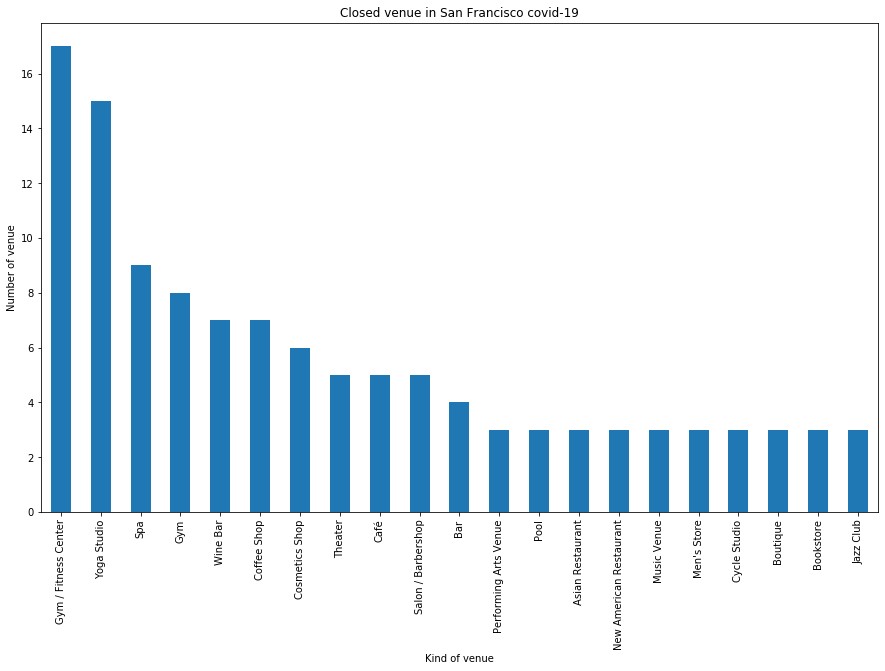

In [315]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

sf_cat_close_sort['sum'].plot(kind='bar', figsize=(15, 9))

plt.xlabel('Kind of venue') # add to x-label to the plot
plt.ylabel('Number of venue') # add y-label to the plot
plt.title('Closed venue in San Francisco covid-19') # add title to the plot

plt.show()

<b>Next I create new df. (Note: I created many new df for comfort. In this case I can faster found mistake if it have. And I do not need recalculate any df). df_cat is df by category with Status. I join name of district to new df then i will sort values by this field</b>

In [329]:
sf_total = sf_cat

In [330]:
sf_total['Neighborhood'] = sf_venues2['Neighborhood']

In [331]:
sf_total

,Accessories Store,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit,Status,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Hayes Valley/Tenderloin/North of Market
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Hayes Valley/Tenderloin/North of Market
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Hayes Valley/Tenderloin/North of Market
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Hayes Valley/Tenderloin/North of Market
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Hayes Valley/Tenderloin/North of Market
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Visitacion Valley/Sunnydale
1816,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Visitacion Valley/Sunnydale
1817,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,Visitacion Valley/Sunnydale
1818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Visitacion Valley/Sunnydale


In [332]:
sf_total = sf_total.groupby('Neighborhood').mean().reset_index()

In [339]:
sf_total

,Neighborhood,Accessories Store,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit,Status
0,Bayview-Hunters Point,0.000000,0.020408,0.00,0.000000,0.000000,0.00,0.00,0.0000,0.00,...,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.00,0.000000,0.000000,0.959184
1,Castro/Noe Valley,0.000000,0.000000,0.00,0.020000,0.000000,0.00,0.00,0.0000,0.00,...,0.000000,0.000000,0.000000,0.00,0.020,0.01,0.00,0.010000,0.000000,0.910000
2,Chinatown,0.000000,0.000000,0.00,0.010000,0.000000,0.00,0.00,0.0200,0.00,...,0.000000,0.000000,0.020000,0.01,0.020,0.00,0.00,0.020000,0.000000,0.770000
3,Haight-Ashbury,0.020000,0.000000,0.00,0.000000,0.000000,0.01,0.00,0.0100,0.00,...,0.000000,0.000000,0.010000,0.00,0.020,0.00,0.00,0.020000,0.000000,0.870000
4,Hayes Valley/Tenderloin/North of Market,0.010000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.0000,0.01,...,0.000000,0.000000,0.040000,0.00,0.020,0.01,0.00,0.010000,0.000000,0.780000
5,Ingelside-Excelsior/Crocker-Amazon,0.000000,0.000000,0.00,0.023256,0.000000,0.00,0.00,0.0000,0.00,...,0.000000,0.000000,0.046512,0.00,0.000,0.00,0.00,0.000000,0.000000,0.918605
6,Inner Mission/Bernal Heights,0.000000,0.000000,0.00,0.020000,0.000000,0.00,0.01,0.0200,0.00,...,0.000000,0.000000,0.010000,0.00,0.000,0.00,0.00,0.020000,0.000000,0.870000
7,Inner Richmond,0.000000,0.000000,0.00,0.020000,0.000000,0.00,0.00,0.0100,0.00,...,0.000000,0.000000,0.030000,0.00,0.020,0.02,0.00,0.010000,0.000000,0.910000
8,Lake Merced,0.015873,0.000000,0.00,0.015873,0.000000,0.00,0.00,0.0000,0.00,...,0.015873,0.000000,0.000000,0.00,0.000,0.00,0.00,0.000000,0.000000,0.841270
9,Marina,0.010000,0.000000,0.01,0.020000,0.000000,0.00,0.00,0.0000,0.00,...,0.000000,0.000000,0.010000,0.00,0.040,0.01,0.00,0.010000,0.000000,0.840000


<b>I create new df for K-mean clustering and leave only necessary columns</b>

In [343]:
sf_total2=sf_total.loc[:, sf_total.columns != 'Status']
sf_total2

,Neighborhood,Accessories Store,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit
0,Bayview-Hunters Point,0.000000,0.020408,0.00,0.000000,0.000000,0.00,0.00,0.0000,0.00,...,0.00,0.000000,0.000000,0.000000,0.00,0.000,0.00,0.00,0.000000,0.000000
1,Castro/Noe Valley,0.000000,0.000000,0.00,0.020000,0.000000,0.00,0.00,0.0000,0.00,...,0.00,0.000000,0.000000,0.000000,0.00,0.020,0.01,0.00,0.010000,0.000000
2,Chinatown,0.000000,0.000000,0.00,0.010000,0.000000,0.00,0.00,0.0200,0.00,...,0.00,0.000000,0.000000,0.020000,0.01,0.020,0.00,0.00,0.020000,0.000000
3,Haight-Ashbury,0.020000,0.000000,0.00,0.000000,0.000000,0.01,0.00,0.0100,0.00,...,0.01,0.000000,0.000000,0.010000,0.00,0.020,0.00,0.00,0.020000,0.000000
4,Hayes Valley/Tenderloin/North of Market,0.010000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.0000,0.01,...,0.02,0.000000,0.000000,0.040000,0.00,0.020,0.01,0.00,0.010000,0.000000
5,Ingelside-Excelsior/Crocker-Amazon,0.000000,0.000000,0.00,0.023256,0.000000,0.00,0.00,0.0000,0.00,...,0.00,0.000000,0.000000,0.046512,0.00,0.000,0.00,0.00,0.000000,0.000000
6,Inner Mission/Bernal Heights,0.000000,0.000000,0.00,0.020000,0.000000,0.00,0.01,0.0200,0.00,...,0.00,0.000000,0.000000,0.010000,0.00,0.000,0.00,0.00,0.020000,0.000000
7,Inner Richmond,0.000000,0.000000,0.00,0.020000,0.000000,0.00,0.00,0.0100,0.00,...,0.00,0.000000,0.000000,0.030000,0.00,0.020,0.02,0.00,0.010000,0.000000
8,Lake Merced,0.015873,0.000000,0.00,0.015873,0.000000,0.00,0.00,0.0000,0.00,...,0.00,0.015873,0.000000,0.000000,0.00,0.000,0.00,0.00,0.000000,0.000000
9,Marina,0.010000,0.000000,0.01,0.020000,0.000000,0.00,0.00,0.0000,0.00,...,0.02,0.000000,0.000000,0.010000,0.00,0.040,0.01,0.00,0.010000,0.000000


<b>On thsi step I groupping venues for each neighbourhood and pick top 10 values. Next I will plot it.</b>


In [344]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# create columns according to number of top venues
columns = ['Neighborhood','Status']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
print(columns)
sf_venues_sorted = pd.DataFrame(columns=columns)
sf_venues_sorted['Neighborhood'] = sf_total['Neighborhood']
sf_venues_sorted['Status'] = sf_total['Status']

for ind in np.arange(sf_total.shape[0]):
    sf_venues_sorted.iloc[ind, 2:] = return_most_common_venues(sf_total2.iloc[ind, :], num_top_venues)

sf_venues_sorted


['Neighborhood', 'Status', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']


,Neighborhood,Status,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview-Hunters Point,0.959184,Southern / Soul Food Restaurant,Park,Bakery,Pizza Place,Light Rail Station,Mexican Restaurant,Café,Furniture / Home Store,Restaurant,Moving Target
1,Castro/Noe Valley,0.910000,Gay Bar,Park,Coffee Shop,New American Restaurant,Juice Bar,Thai Restaurant,Bakery,Playground,Farmers Market,Sandwich Place
2,Chinatown,0.770000,Coffee Shop,Hotel,Boutique,Sushi Restaurant,Men's Store,Cocktail Bar,Italian Restaurant,Bubble Tea Shop,Bakery,Restaurant
3,Haight-Ashbury,0.870000,Park,Coffee Shop,Café,Bookstore,Pizza Place,Playground,Ice Cream Shop,Shoe Store,Breakfast Spot,Boutique
4,Hayes Valley/Tenderloin/North of Market,0.780000,Coffee Shop,Theater,Vietnamese Restaurant,French Restaurant,Bakery,Beer Bar,Marijuana Dispensary,Thai Restaurant,Cocktail Bar,Sandwich Place
5,Ingelside-Excelsior/Crocker-Amazon,0.918605,Mexican Restaurant,Latin American Restaurant,Vietnamese Restaurant,Liquor Store,Pizza Place,Sandwich Place,Coffee Shop,Bakery,Grocery Store,Bar
6,Inner Mission/Bernal Heights,0.870000,Mexican Restaurant,Coffee Shop,Grocery Store,Pizza Place,New American Restaurant,Café,Italian Restaurant,Gym / Fitness Center,Performing Arts Venue,Fish Market
7,Inner Richmond,0.910000,Park,Chinese Restaurant,Bakery,Japanese Restaurant,Thai Restaurant,Vietnamese Restaurant,Coffee Shop,Burmese Restaurant,Asian Restaurant,Sushi Restaurant
8,Lake Merced,0.841270,Sandwich Place,Clothing Store,Park,Bakery,Juice Bar,Cosmetics Shop,Mobile Phone Shop,Café,Candy Store,Trail
9,Marina,0.840000,Italian Restaurant,Gym / Fitness Center,Wine Bar,Cosmetics Shop,French Restaurant,Sandwich Place,Coffee Shop,Playground,Thai Restaurant,Salad Place


<b>df_top10 created for plotting only</b>

In [413]:
df_top10=sf_venues_sorted.drop(columns = ['Status','Neighborhood'])

In [414]:
df_top10 = df_top10.apply(pd.Series.value_counts).fillna(0)

In [415]:
df_top10

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Art Gallery,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
Asian Restaurant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Bakery,1.0,1.0,3.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0
Bank,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Bar,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...
Theater,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Trail,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
Vietnamese Restaurant,0.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
Wine Bar,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [416]:
df_top10['Sum'] = df_top10.sum(axis=1)
df_top10 = df_top10[df_top10['Sum']>1].sort_values('Sum', ascending=False)

In [417]:
df_top10

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Sum
Coffee Shop,4.0,2.0,2.0,2.0,1.0,0.0,3.0,0.0,1.0,0.0,15.0
Park,5.0,4.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,14.0
Bakery,1.0,1.0,3.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,12.0
Pizza Place,1.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,1.0,10.0
Sandwich Place,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,10.0
Café,0.0,1.0,2.0,1.0,0.0,2.0,1.0,2.0,1.0,0.0,10.0
Italian Restaurant,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,6.0
Sushi Restaurant,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,6.0
Vietnamese Restaurant,0.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,6.0
Gym / Fitness Center,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0


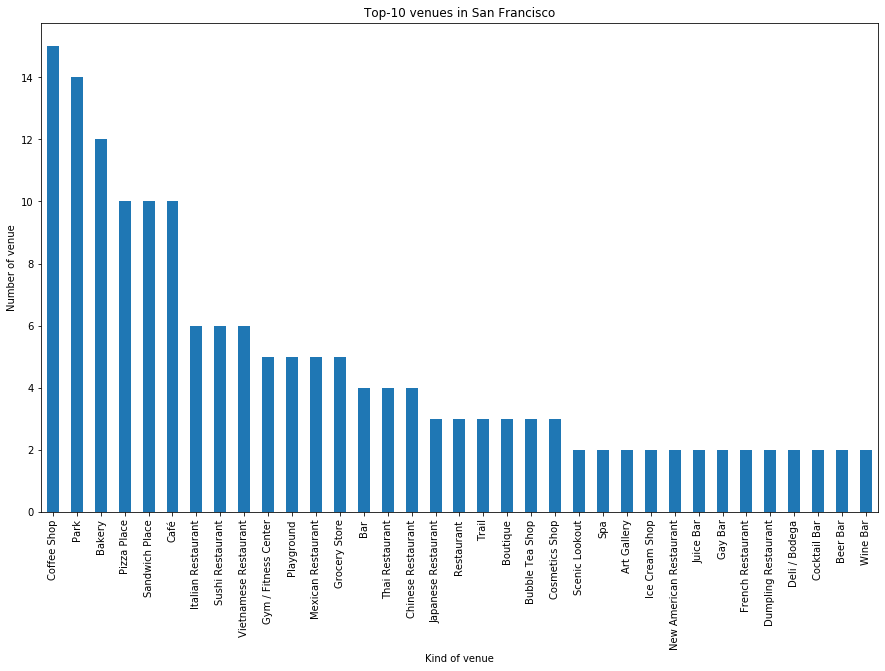

In [419]:
df_top10['Sum'].plot(kind='bar', figsize=(15, 9))

plt.xlabel('Kind of venue') # add to x-label to the plot
plt.ylabel('Number of venue') # add y-label to the plot
plt.title('Top-10 venues in San Francisco') # add title to the plot

plt.show()

<b>Lets make a clusters and visualize it. I take df which a created earlier.</b>

In [423]:
# set number of clusters
kclusters = 5

sf_grouped_clustering = sf_total2.drop(columns = ['Neighborhood'])
sf_grouped_clustering
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 3, 3, 1, 1, 2, 1, 3, 1, 4, 1],
      dtype=int32)

<b>df sf_venues_sorted this is df with top 10 kind of venue for every district. After K-mean clustering I insert value of cluster for df</b>

In [424]:
sf_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [425]:
sf_venues_sorted

,Cluster Labels,Neighborhood,Status,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Bayview-Hunters Point,0.959184,Southern / Soul Food Restaurant,Park,Bakery,Pizza Place,Light Rail Station,Mexican Restaurant,Café,Furniture / Home Store,Restaurant,Moving Target
1,1,Castro/Noe Valley,0.910000,Gay Bar,Park,Coffee Shop,New American Restaurant,Juice Bar,Thai Restaurant,Bakery,Playground,Farmers Market,Sandwich Place
2,2,Chinatown,0.770000,Coffee Shop,Hotel,Boutique,Sushi Restaurant,Men's Store,Cocktail Bar,Italian Restaurant,Bubble Tea Shop,Bakery,Restaurant
3,1,Haight-Ashbury,0.870000,Park,Coffee Shop,Café,Bookstore,Pizza Place,Playground,Ice Cream Shop,Shoe Store,Breakfast Spot,Boutique
4,2,Hayes Valley/Tenderloin/North of Market,0.780000,Coffee Shop,Theater,Vietnamese Restaurant,French Restaurant,Bakery,Beer Bar,Marijuana Dispensary,Thai Restaurant,Cocktail Bar,Sandwich Place
5,1,Ingelside-Excelsior/Crocker-Amazon,0.918605,Mexican Restaurant,Latin American Restaurant,Vietnamese Restaurant,Liquor Store,Pizza Place,Sandwich Place,Coffee Shop,Bakery,Grocery Store,Bar
6,1,Inner Mission/Bernal Heights,0.870000,Mexican Restaurant,Coffee Shop,Grocery Store,Pizza Place,New American Restaurant,Café,Italian Restaurant,Gym / Fitness Center,Performing Arts Venue,Fish Market
7,2,Inner Richmond,0.910000,Park,Chinese Restaurant,Bakery,Japanese Restaurant,Thai Restaurant,Vietnamese Restaurant,Coffee Shop,Burmese Restaurant,Asian Restaurant,Sushi Restaurant
8,2,Lake Merced,0.841270,Sandwich Place,Clothing Store,Park,Bakery,Juice Bar,Cosmetics Shop,Mobile Phone Shop,Café,Candy Store,Trail
9,2,Marina,0.840000,Italian Restaurant,Gym / Fitness Center,Wine Bar,Cosmetics Shop,French Restaurant,Sandwich Place,Coffee Shop,Playground,Thai Restaurant,Salad Place


<b>I am coming back to first df_nh. Remind, it is first df with neighborhoods and coordinates. I merged two df for drowing map with clusters. Lets look at map.</b>

In [431]:
df_nh = df_nh.reset_index(drop=True)

In [435]:
sf_merged = df_nh
sf_merged = sf_merged.drop(columns=['Neighborhood'])

In [437]:
sf_merged = sf_merged.join(sf_venues_sorted)

In [438]:
sf_merged

,Zip Code,Population (Census 2000),Latitude,Longitude,Cluster Labels,Neighborhood,Status,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94102,28991,37.7797,-122.419,0,Bayview-Hunters Point,0.959184,Southern / Soul Food Restaurant,Park,Bakery,Pizza Place,Light Rail Station,Mexican Restaurant,Café,Furniture / Home Store,Restaurant,Moving Target
1,94103,23016,37.7732,-122.411,1,Castro/Noe Valley,0.910000,Gay Bar,Park,Coffee Shop,New American Restaurant,Juice Bar,Thai Restaurant,Bakery,Playground,Farmers Market,Sandwich Place
2,94107,17368,37.7664,-122.395,2,Chinatown,0.770000,Coffee Shop,Hotel,Boutique,Sushi Restaurant,Men's Store,Cocktail Bar,Italian Restaurant,Bubble Tea Shop,Bakery,Restaurant
3,94108,13716,37.792,-122.409,1,Haight-Ashbury,0.870000,Park,Coffee Shop,Café,Bookstore,Pizza Place,Playground,Ice Cream Shop,Shoe Store,Breakfast Spot,Boutique
4,94109,56322,37.7952,-122.422,2,Hayes Valley/Tenderloin/North of Market,0.780000,Coffee Shop,Theater,Vietnamese Restaurant,French Restaurant,Bakery,Beer Bar,Marijuana Dispensary,Thai Restaurant,Cocktail Bar,Sandwich Place
5,94110,74633,37.75,-122.415,1,Ingelside-Excelsior/Crocker-Amazon,0.918605,Mexican Restaurant,Latin American Restaurant,Vietnamese Restaurant,Liquor Store,Pizza Place,Sandwich Place,Coffee Shop,Bakery,Grocery Store,Bar
6,94112,73104,37.7203,-122.443,1,Inner Mission/Bernal Heights,0.870000,Mexican Restaurant,Coffee Shop,Grocery Store,Pizza Place,New American Restaurant,Café,Italian Restaurant,Gym / Fitness Center,Performing Arts Venue,Fish Market
7,94114,30574,37.758,-122.435,2,Inner Richmond,0.910000,Park,Chinese Restaurant,Bakery,Japanese Restaurant,Thai Restaurant,Vietnamese Restaurant,Coffee Shop,Burmese Restaurant,Asian Restaurant,Sushi Restaurant
8,94115,33115,37.786,-122.437,2,Lake Merced,0.841270,Sandwich Place,Clothing Store,Park,Bakery,Juice Bar,Cosmetics Shop,Mobile Phone Shop,Café,Candy Store,Trail
9,94116,42958,37.7446,-122.486,2,Marina,0.840000,Italian Restaurant,Gym / Fitness Center,Wine Bar,Cosmetics Shop,French Restaurant,Sandwich Place,Coffee Shop,Playground,Thai Restaurant,Salad Place


In [440]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged['Latitude'], sf_merged['Longitude'], sf_merged['Neighborhood'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<b>Next, I want to give names for clusters groups. I will estimate value and plot histogram. You can see it scrolling down.</b>

In [564]:
groups = sf_merged.groupby('Cluster Labels') # groupping by cluster

In [565]:
group1 = groups.get_group(1) # get group by cluster value

In [566]:
group1

,Zip Code,Population (Census 2000),Latitude,Longitude,Cluster Labels,Neighborhood,Status,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,94103,23016,37.7732,-122.411,1,Castro/Noe Valley,0.910000,Gay Bar,Park,Coffee Shop,New American Restaurant,Juice Bar,Thai Restaurant,Bakery,Playground,Farmers Market,Sandwich Place
3,94108,13716,37.792,-122.409,1,Haight-Ashbury,0.870000,Park,Coffee Shop,Café,Bookstore,Pizza Place,Playground,Ice Cream Shop,Shoe Store,Breakfast Spot,Boutique
5,94110,74633,37.75,-122.415,1,Ingelside-Excelsior/Crocker-Amazon,0.918605,Mexican Restaurant,Latin American Restaurant,Vietnamese Restaurant,Liquor Store,Pizza Place,Sandwich Place,Coffee Shop,Bakery,Grocery Store,Bar
6,94112,73104,37.7203,-122.443,1,Inner Mission/Bernal Heights,0.870000,Mexican Restaurant,Coffee Shop,Grocery Store,Pizza Place,New American Restaurant,Café,Italian Restaurant,Gym / Fitness Center,Performing Arts Venue,Fish Market
10,94117,38738,37.7698,-122.448,1,North Beach/Chinatown,0.930000,Pizza Place,Bakery,Coffee Shop,Park,Seafood Restaurant,Café,Deli / Bodega,Trail,Italian Restaurant,Scenic Lookout
13,94122,55492,37.7588,-122.485,1,Polk/Russian Hill (Nob Hill),0.880000,Italian Restaurant,Park,Grocery Store,Coffee Shop,Deli / Bodega,Wine Bar,Vietnamese Restaurant,Gym / Fitness Center,Steakhouse,Bar
14,94123,22903,37.8005,-122.438,1,Potrero Hill,0.810000,Coffee Shop,Park,Café,Food Truck,Bar,Pizza Place,Brewery,Sandwich Place,Yoga Studio,Sushi Restaurant
16,94127,20624,37.7357,-122.459,1,St. Francis Wood/Miraloma/West Portal,0.887500,Park,Pub,Sushi Restaurant,Coffee Shop,Burger Joint,Spa,Bus Line,Café,Mexican Restaurant,Grocery Store
18,94132,26291,37.7221,-122.485,1,Twin Peaks-Glen Park,0.925373,Park,Playground,Scenic Lookout,Trail,Coffee Shop,Italian Restaurant,Sandwich Place,Grocery Store,Café,Pharmacy
20,94134,40134,37.7194,-122.412,1,Western Addition/Japantown,0.850000,Bakery,Ice Cream Shop,Park,Cosmetics Shop,Spa,Tea Room,Boutique,Gym / Fitness Center,Pizza Place,Sandwich Place


In [576]:
group2 = groups.get_group(2)
group2

,Zip Code,Population (Census 2000),Latitude,Longitude,Cluster Labels,Neighborhood,Status,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,94107,17368,37.7664,-122.395,2,Chinatown,0.77000,Coffee Shop,Hotel,Boutique,Sushi Restaurant,Men's Store,Cocktail Bar,Italian Restaurant,Bubble Tea Shop,Bakery,Restaurant
4,94109,56322,37.7952,-122.422,2,Hayes Valley/Tenderloin/North of Market,0.78000,Coffee Shop,Theater,Vietnamese Restaurant,French Restaurant,Bakery,Beer Bar,Marijuana Dispensary,Thai Restaurant,Cocktail Bar,Sandwich Place
7,94114,30574,37.758,-122.435,2,Inner Richmond,0.91000,Park,Chinese Restaurant,Bakery,Japanese Restaurant,Thai Restaurant,Vietnamese Restaurant,Coffee Shop,Burmese Restaurant,Asian Restaurant,Sushi Restaurant
8,94115,33115,37.786,-122.437,2,Lake Merced,0.84127,Sandwich Place,Clothing Store,Park,Bakery,Juice Bar,Cosmetics Shop,Mobile Phone Shop,Café,Candy Store,Trail
9,94116,42958,37.7446,-122.486,2,Marina,0.84000,Italian Restaurant,Gym / Fitness Center,Wine Bar,Cosmetics Shop,French Restaurant,Sandwich Place,Coffee Shop,Playground,Thai Restaurant,Salad Place
15,94124,33170,37.7308,-122.385,2,South of Market,0.80000,Coffee Shop,Gym / Fitness Center,Restaurant,Dance Studio,Motorcycle Shop,Art Gallery,Bakery,Beer Bar,Pizza Place,Gay Bar


In [558]:
col = columns[1:]

In [559]:
col

['1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue']

In [568]:
group1 = group1[col]

In [569]:
group1 = group1.apply(pd.Series.value_counts).fillna(0) # count values for whole df

In [570]:
group1

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Bakery,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Bar,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
Bookstore,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Boutique,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
Breakfast Spot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Brewery,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Burger Joint,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Bus Line,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Café,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0
Coffee Shop,1.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0


In [571]:
group1['Sum'] = group1.sum(axis=1)
group1 = group1.sort_values('Sum', ascending=False)

In [573]:
group1.head(5)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Sum
Coffee Shop,1.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,9.0
Park,3.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
Pizza Place,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,6.0
Café,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,6.0
Sandwich Place,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,5.0


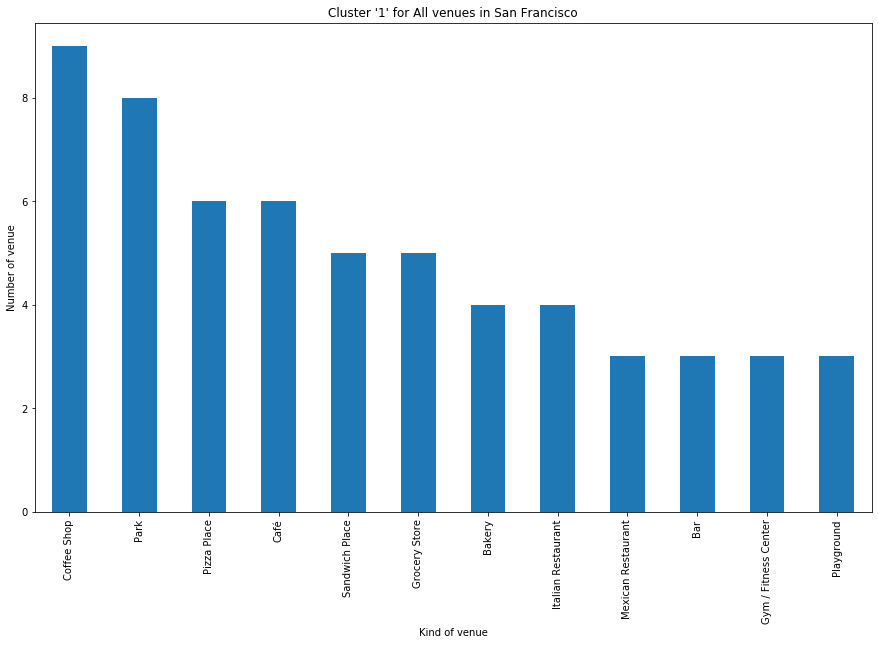

In [615]:
group1 = group1[group1['Sum']>2]
group1['Sum'].plot(kind='bar', figsize=(15, 9))

plt.xlabel('Kind of venue') # add to x-label to the plot
plt.ylabel('Number of venue') # add y-label to the plot
plt.title("Cluster '1' for All venues in San Francisco") # add title to the plot

plt.show()

In [577]:
group2 = group2[col]
group2 = group2.apply(pd.Series.value_counts).fillna(0)
group2['Sum'] = group2.sum(axis=1)
group2 = group2.sort_values('Sum', ascending=False)
group2.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Sum
Coffee Shop,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0
Bakery,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,5.0
Thai Restaurant,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0
Sandwich Place,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0
Italian Restaurant,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0


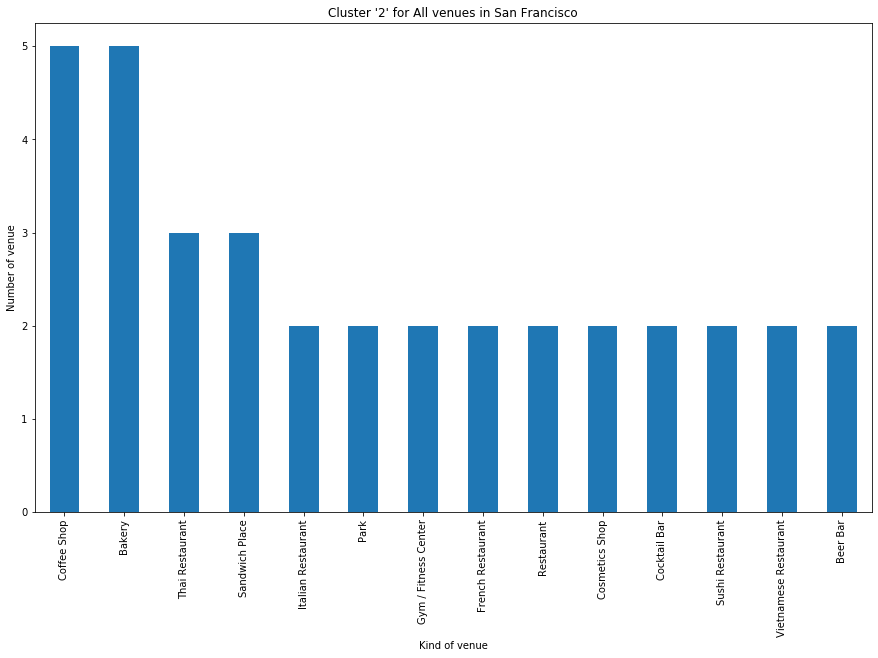

In [618]:
group2 = group2[group2['Sum']>1]
group2['Sum'].plot(kind='bar', figsize=(15, 9))

plt.xlabel('Kind of venue') # add to x-label to the plot
plt.ylabel('Number of venue') # add y-label to the plot
plt.title("Cluster '2' for All venues in San Francisco") # add title to the plot

plt.show()

<h2>Results</h2>

<b>My goal was to show distribution of businesses opened and closed so far.

I divided data for Closed and Opened venue (remind: I have got business status in the start of work thru parsing) and repeated all steps from above for each class.</b>
 

In [507]:
df_oc = pd.read_csv('sf_venues2.csv')

<b>I am repeating all steps from above for only Opened venues.I will calculate new clusters and drow new map. Then I will estimate new clusters</b>

In [508]:
sf_open = df_oc[df_oc['Status'] == 'Open']

In [509]:
sf_open.columns

Index(['Unnamed: 0', 'Neighborhood', 'Neighborhood Latitude',
       'Neighborhood Longitude', 'Venue', 'Venue Adress', 'Venue Latitude',
       'Venue Longitude', 'Venue Category', 'Status'],
      dtype='object')

In [510]:
sf_open = sf_open.drop(columns=['Unnamed: 0'])
sf_open = sf_open.reset_index(drop=True)

In [514]:
sf_open

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Adress,Venue Latitude,Venue Longitude,Venue Category,Status
0,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Louise M. Davies Symphony Hall,"['201 Van Ness Ave (btwn Grove & Hayes St)', '...",37.777976,-122.420157,Concert Hall,Open
1,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,San Francisco Ballet,"['455 Franklin St (btw Fulton & Grove)', 'San ...",37.778580,-122.420798,Dance Studio,Open
2,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,War Memorial Court,"['Van Ness Ave (Fulton St)', 'San Francisco, C...",37.779042,-122.420971,Park,Open
3,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Philz Coffee,"['399 Golden Gate Ave (Larkin)', 'San Francisc...",37.781266,-122.416901,Coffee Shop,Open
4,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Whitechapel,"['600 Polk St (btwn Eddy and Turk St)', 'San F...",37.782230,-122.418884,Cocktail Bar,Open
...,...,...,...,...,...,...,...,...,...
1591,Visitacion Valley/Sunnydale,37.71938,-122.41180,Little Village,"['San Francisco, CA', 'United States']",37.712086,-122.415726,Liquor Store,Open
1592,Visitacion Valley/Sunnydale,37.71938,-122.41180,Visitacion Valley Playground Baseball Field,"['700 Delta (Visitacion Ave)', 'San Francisco,...",37.711423,-122.410775,Baseball Field,Open
1593,Visitacion Valley/Sunnydale,37.71938,-122.41180,Philosopher's Way,"['McLaren Park', 'San Francisco, CA 94134', 'U...",37.720126,-122.422401,Art Gallery,Open
1594,Visitacion Valley/Sunnydale,37.71938,-122.41180,MUNI Bus Stop - Visitacion Ave & Rutland St,"['San Francisco, CA', 'United States']",37.711335,-122.407566,Bus Stop,Open


In [511]:
sf_open_cat = pd.get_dummies(sf_open[['Venue Category']], prefix="", prefix_sep="")

In [512]:
sf_open_cat

,Accessories Store,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1592,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1593,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [515]:
sf_open_cat['Neighborhood'] = sf_open['Neighborhood']
sf_open_grouped = sf_open_cat.groupby('Neighborhood').mean().reset_index()
sf_open_grouped

,Neighborhood,Accessories Store,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit
0,Bayview-Hunters Point,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Castro/Noe Valley,0.000000,0.000000,0.000000,0.010989,0.000000,0.000000,0.000000,0.000000,0.010989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.021978,0.010989,0.000000,0.000000,0.000000
2,Chinatown,0.000000,0.000000,0.000000,0.012987,0.000000,0.000000,0.000000,0.012987,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.025974,0.012987,0.000000,0.000000,0.025974,0.000000
3,Haight-Ashbury,0.011494,0.000000,0.000000,0.000000,0.000000,0.011494,0.000000,0.011494,0.000000,...,0.000000,0.011494,0.000000,0.000000,0.011494,0.022989,0.000000,0.000000,0.022989,0.000000
4,Hayes Valley/Tenderloin/North of Market,0.012821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.025641,0.000000,0.000000,0.051282,0.012821,0.012821,0.000000,0.000000,0.000000
5,Ingelside-Excelsior/Crocker-Amazon,0.000000,0.000000,0.000000,0.025316,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.050633,0.000000,0.000000,0.000000,0.000000,0.000000
6,Inner Mission/Bernal Heights,0.000000,0.000000,0.000000,0.022989,0.000000,0.000000,0.011494,0.022989,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.011494,0.000000,0.000000,0.000000,0.000000,0.000000
7,Inner Richmond,0.000000,0.000000,0.000000,0.021978,0.000000,0.000000,0.000000,0.010989,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.032967,0.010989,0.021978,0.000000,0.000000,0.000000
8,Lake Merced,0.018868,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.018868,0.000000,0.018868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Marina,0.011905,0.000000,0.011905,0.023810,0.000000,0.000000,0.000000,0.000000,0.011905,...,0.000000,0.011905,0.000000,0.000000,0.011905,0.035714,0.011905,0.000000,0.000000,0.000000


In [519]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


print(columns)
sf_open_sorted = pd.DataFrame(columns=columns)
sf_open_sorted['Neighborhood'] = sf_open_grouped['Neighborhood']

for ind in np.arange(sf_open_grouped.shape[0]):
    sf_open_sorted.iloc[ind, 1:] = return_most_common_venues(sf_open_grouped.iloc[ind, :], num_top_venues)

sf_open_sorted

['Neighborhood', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview-Hunters Point,Park,Bakery,Southern / Soul Food Restaurant,Café,Light Rail Station,Pizza Place,Mexican Restaurant,Garden,Latin American Restaurant,Bistro
1,Castro/Noe Valley,Gay Bar,Park,Coffee Shop,Juice Bar,Thai Restaurant,Bakery,Ice Cream Shop,Farmers Market,Bookstore,New American Restaurant
2,Chinatown,Coffee Shop,Hotel,Italian Restaurant,Cocktail Bar,Boutique,Sushi Restaurant,Bubble Tea Shop,Yoga Studio,Men's Store,Church
3,Haight-Ashbury,Park,Coffee Shop,Café,Pizza Place,Breakfast Spot,Shoe Store,Boutique,Ice Cream Shop,Gift Shop,Mexican Restaurant
4,Hayes Valley/Tenderloin/North of Market,Coffee Shop,Vietnamese Restaurant,Thai Restaurant,Bakery,Beer Bar,Marijuana Dispensary,Cocktail Bar,Juice Bar,Ice Cream Shop,Sushi Restaurant
5,Ingelside-Excelsior/Crocker-Amazon,Mexican Restaurant,Latin American Restaurant,Liquor Store,Pizza Place,Vietnamese Restaurant,Sandwich Place,Coffee Shop,Bakery,Bus Station,Bubble Tea Shop
6,Inner Mission/Bernal Heights,Mexican Restaurant,Grocery Store,Coffee Shop,Pizza Place,Burrito Place,Latin American Restaurant,Café,Bookstore,Fish Market,Italian Restaurant
7,Inner Richmond,Park,Bakery,Chinese Restaurant,Thai Restaurant,Japanese Restaurant,Sushi Restaurant,Café,Korean Restaurant,Vietnamese Restaurant,Burmese Restaurant
8,Lake Merced,Park,Clothing Store,Bakery,Sandwich Place,Trail,Candy Store,Pizza Place,Cosmetics Shop,Mexican Restaurant,Juice Bar
9,Marina,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Wine Bar,French Restaurant,Juice Bar,Electronics Store,Diner,Deli / Bodega,Thai Restaurant


In [520]:
# set number of clusters
kclusters = 5

sf_open_clustering = sf_open_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_open_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 0, 4, 0, 4, 2, 2, 1, 0, 4, 0, 1, 1, 0, 0, 4, 0, 1, 0, 3, 0],
      dtype=int32)

In [521]:
sf_open_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [522]:
sf_open_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Bayview-Hunters Point,Park,Bakery,Southern / Soul Food Restaurant,Café,Light Rail Station,Pizza Place,Mexican Restaurant,Garden,Latin American Restaurant,Bistro
1,0,Castro/Noe Valley,Gay Bar,Park,Coffee Shop,Juice Bar,Thai Restaurant,Bakery,Ice Cream Shop,Farmers Market,Bookstore,New American Restaurant
2,4,Chinatown,Coffee Shop,Hotel,Italian Restaurant,Cocktail Bar,Boutique,Sushi Restaurant,Bubble Tea Shop,Yoga Studio,Men's Store,Church
3,0,Haight-Ashbury,Park,Coffee Shop,Café,Pizza Place,Breakfast Spot,Shoe Store,Boutique,Ice Cream Shop,Gift Shop,Mexican Restaurant
4,4,Hayes Valley/Tenderloin/North of Market,Coffee Shop,Vietnamese Restaurant,Thai Restaurant,Bakery,Beer Bar,Marijuana Dispensary,Cocktail Bar,Juice Bar,Ice Cream Shop,Sushi Restaurant
5,2,Ingelside-Excelsior/Crocker-Amazon,Mexican Restaurant,Latin American Restaurant,Liquor Store,Pizza Place,Vietnamese Restaurant,Sandwich Place,Coffee Shop,Bakery,Bus Station,Bubble Tea Shop
6,2,Inner Mission/Bernal Heights,Mexican Restaurant,Grocery Store,Coffee Shop,Pizza Place,Burrito Place,Latin American Restaurant,Café,Bookstore,Fish Market,Italian Restaurant
7,1,Inner Richmond,Park,Bakery,Chinese Restaurant,Thai Restaurant,Japanese Restaurant,Sushi Restaurant,Café,Korean Restaurant,Vietnamese Restaurant,Burmese Restaurant
8,0,Lake Merced,Park,Clothing Store,Bakery,Sandwich Place,Trail,Candy Store,Pizza Place,Cosmetics Shop,Mexican Restaurant,Juice Bar
9,4,Marina,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Wine Bar,French Restaurant,Juice Bar,Electronics Store,Diner,Deli / Bodega,Thai Restaurant


In [526]:
sf_open_merged = df_nh
sf_open_merged = sf_open_merged.drop(columns=['Neighborhood'])
sf_open_merged
sf_open_merged = sf_open_merged.join(sf_open_sorted)
sf_open_merged 

,Zip Code,Population (Census 2000),Latitude,Longitude,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94102,28991,37.7797,-122.419,0,Bayview-Hunters Point,Park,Bakery,Southern / Soul Food Restaurant,Café,Light Rail Station,Pizza Place,Mexican Restaurant,Garden,Latin American Restaurant,Bistro
1,94103,23016,37.7732,-122.411,0,Castro/Noe Valley,Gay Bar,Park,Coffee Shop,Juice Bar,Thai Restaurant,Bakery,Ice Cream Shop,Farmers Market,Bookstore,New American Restaurant
2,94107,17368,37.7664,-122.395,4,Chinatown,Coffee Shop,Hotel,Italian Restaurant,Cocktail Bar,Boutique,Sushi Restaurant,Bubble Tea Shop,Yoga Studio,Men's Store,Church
3,94108,13716,37.792,-122.409,0,Haight-Ashbury,Park,Coffee Shop,Café,Pizza Place,Breakfast Spot,Shoe Store,Boutique,Ice Cream Shop,Gift Shop,Mexican Restaurant
4,94109,56322,37.7952,-122.422,4,Hayes Valley/Tenderloin/North of Market,Coffee Shop,Vietnamese Restaurant,Thai Restaurant,Bakery,Beer Bar,Marijuana Dispensary,Cocktail Bar,Juice Bar,Ice Cream Shop,Sushi Restaurant
5,94110,74633,37.75,-122.415,2,Ingelside-Excelsior/Crocker-Amazon,Mexican Restaurant,Latin American Restaurant,Liquor Store,Pizza Place,Vietnamese Restaurant,Sandwich Place,Coffee Shop,Bakery,Bus Station,Bubble Tea Shop
6,94112,73104,37.7203,-122.443,2,Inner Mission/Bernal Heights,Mexican Restaurant,Grocery Store,Coffee Shop,Pizza Place,Burrito Place,Latin American Restaurant,Café,Bookstore,Fish Market,Italian Restaurant
7,94114,30574,37.758,-122.435,1,Inner Richmond,Park,Bakery,Chinese Restaurant,Thai Restaurant,Japanese Restaurant,Sushi Restaurant,Café,Korean Restaurant,Vietnamese Restaurant,Burmese Restaurant
8,94115,33115,37.786,-122.437,0,Lake Merced,Park,Clothing Store,Bakery,Sandwich Place,Trail,Candy Store,Pizza Place,Cosmetics Shop,Mexican Restaurant,Juice Bar
9,94116,42958,37.7446,-122.486,4,Marina,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Wine Bar,French Restaurant,Juice Bar,Electronics Store,Diner,Deli / Bodega,Thai Restaurant


<b>As you can see, the distributions of clusters for Opened places differs from the initial state in the number of cluster elements.</b>

In [527]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_open_merged ['Latitude'], sf_open_merged['Longitude'], sf_open_merged['Neighborhood'], sf_open_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [578]:
groups_open = sf_open_merged.groupby('Cluster Labels')

In [582]:
group1_open = groups_open.get_group(0)
group1_open                            

,Zip Code,Population (Census 2000),Latitude,Longitude,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94102,28991,37.7797,-122.419,0,Bayview-Hunters Point,Park,Bakery,Southern / Soul Food Restaurant,Café,Light Rail Station,Pizza Place,Mexican Restaurant,Garden,Latin American Restaurant,Bistro
1,94103,23016,37.7732,-122.411,0,Castro/Noe Valley,Gay Bar,Park,Coffee Shop,Juice Bar,Thai Restaurant,Bakery,Ice Cream Shop,Farmers Market,Bookstore,New American Restaurant
3,94108,13716,37.792,-122.409,0,Haight-Ashbury,Park,Coffee Shop,Café,Pizza Place,Breakfast Spot,Shoe Store,Boutique,Ice Cream Shop,Gift Shop,Mexican Restaurant
8,94115,33115,37.786,-122.437,0,Lake Merced,Park,Clothing Store,Bakery,Sandwich Place,Trail,Candy Store,Pizza Place,Cosmetics Shop,Mexican Restaurant,Juice Bar
10,94117,38738,37.7698,-122.448,0,North Beach/Chinatown,Bakery,Coffee Shop,Pizza Place,Park,Seafood Restaurant,Café,Deli / Bodega,Trail,Scenic Lookout,Italian Restaurant
13,94122,55492,37.7588,-122.485,0,Polk/Russian Hill (Nob Hill),Italian Restaurant,Park,Grocery Store,Wine Bar,Vietnamese Restaurant,Deli / Bodega,Bar,Sushi Restaurant,Massage Studio,Pizza Place
14,94123,22903,37.8005,-122.438,0,Potrero Hill,Park,Coffee Shop,Food Truck,Sandwich Place,Café,Pizza Place,Sushi Restaurant,Mexican Restaurant,Furniture / Home Store,Brewery
16,94127,20624,37.7357,-122.459,0,St. Francis Wood/Miraloma/West Portal,Park,Sushi Restaurant,Coffee Shop,Playground,Italian Restaurant,Breakfast Spot,Burger Joint,Bus Line,Café,Jewelry Store
18,94132,26291,37.7221,-122.485,0,Twin Peaks-Glen Park,Park,Scenic Lookout,Trail,Playground,Coffee Shop,Gift Shop,Sandwich Place,Café,Grocery Store,Italian Restaurant
20,94134,40134,37.7194,-122.412,0,Western Addition/Japantown,Bakery,Ice Cream Shop,Park,Cosmetics Shop,Sushi Restaurant,Sandwich Place,Pizza Place,Boutique,Bookstore,New American Restaurant


In [583]:
group1_open = group1_open[col]
group1_open = group1_open.apply(pd.Series.value_counts).fillna(0)
group1_open['Sum'] = group1_open.sum(axis=1)
group1_open = group1_open.sort_values('Sum', ascending=False)
group1_open.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Sum
Park,6.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
Pizza Place,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,7.0
Coffee Shop,0.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0
Café,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,6.0
Bakery,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0


<b>Main and biggest cluster also have same top kind of venue</b>

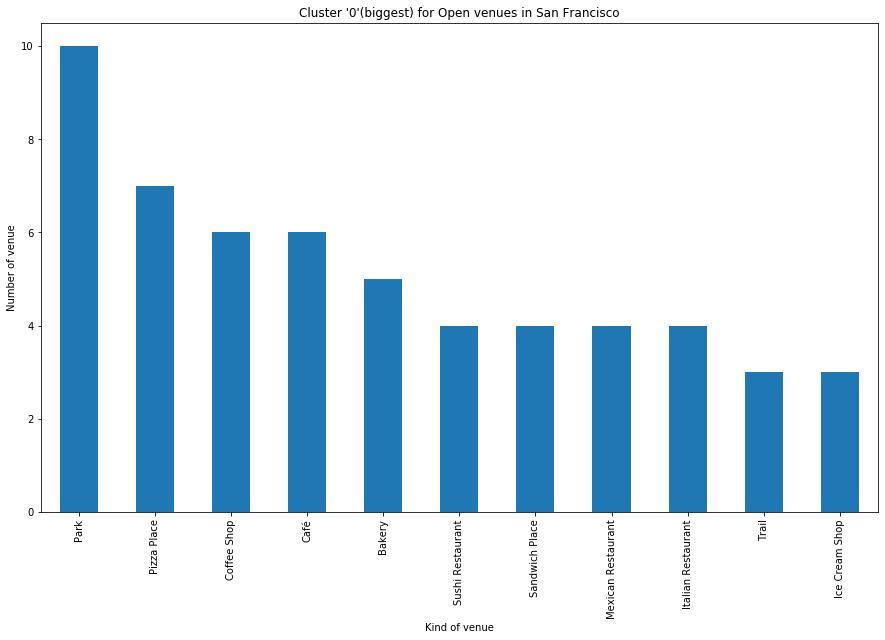

In [614]:
group1_open = group1_open[group1_open['Sum']>2]
group1_open['Sum'].plot(kind='bar', figsize=(15, 9))

plt.xlabel('Kind of venue') # add to x-label to the plot
plt.ylabel('Number of venue') # add y-label to the plot
plt.title("Cluster '0'(biggest) for Open venues in San Francisco") # add title to the plot

plt.show()

In [584]:
group2_open = groups_open.get_group(1)
group2_open = group2_open[col]
group2_open = group2_open.apply(pd.Series.value_counts).fillna(0)
group2_open['Sum'] = group2_open.sum(axis=1)
group2_open = group2_open.sort_values('Sum', ascending=False)
group2_open.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Sum
Chinese Restaurant,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
Bakery,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
Sushi Restaurant,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0
Park,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0
Japanese Restaurant,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0


In [585]:
group3_open = groups_open.get_group(2)
group3_open = group3_open[col]
group3_open = group3_open.apply(pd.Series.value_counts).fillna(0)
group3_open['Sum'] = group3_open.sum(axis=1)
group3_open = group3_open.sort_values('Sum', ascending=False)
group3_open.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Sum
Coffee Shop,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
Latin American Restaurant,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
Mexican Restaurant,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
Pizza Place,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
Bakery,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [589]:
group4_open = groups_open.get_group(4)
group4_open = group4_open[col]
group4_open = group4_open.apply(pd.Series.value_counts).fillna(0)
group4_open['Sum'] = group4_open.sum(axis=1)
group4_open = group4_open.sort_values('Sum', ascending=False)
group4_open.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Sum
Coffee Shop,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
Bakery,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
Italian Restaurant,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
Wine Bar,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
Thai Restaurant,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


<b>I am repeating all steps from above for only Closed venues.I will calculate new clusters and drow new map. Then I will estimate new clusters</b>

In [590]:
df_oc = pd.read_csv('sf_venues2.csv')

In [593]:
sf_close = df_oc[df_oc['Status'] == 'Closed']
sf_close

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Adress,Venue Latitude,Venue Longitude,Venue Category,Status
1,1,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,War Memorial Opera House,"['301 Van Ness Ave (at Grove St)', 'San Franci...",37.778601,-122.420816,Opera House,Closed
2,2,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Herbst Theater,"['401 Van Ness Ave (at McAllister St)', 'San F...",37.779548,-122.420953,Concert Hall,Closed
4,4,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Asian Art Museum,"['200 Larkin St (at McAllister St)', 'San Fran...",37.780178,-122.416505,Art Museum,Closed
8,8,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Main Stage Of Davies Symphony Hall,"['San Francisco, CA 94102', 'United States']",37.777703,-122.420476,Performing Arts Venue,Closed
11,11,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,SFJazz Center,"['201 Franklin St (at Fell St)', 'San Francisc...",37.776350,-122.421539,Jazz Club,Closed
...,...,...,...,...,...,...,...,...,...,...
1777,1777,North Beach/Chinatown,37.80381,-122.41073,Eight Tables by George Chen,"['8 Kenneth Rexroth Pl', 'San Francisco, CA 94...",37.798355,-122.407792,Chinese Restaurant,Closed
1781,1781,North Beach/Chinatown,37.80381,-122.41073,Carmel Pizza Company,"['2826 Jones St. (Beach & Jefferson)', 'San Fr...",37.807532,-122.417287,Pizza Place,Closed
1790,1790,North Beach/Chinatown,37.80381,-122.41073,Musée Mécanique,"['Pier 45, Shed A (at Taylor St)', 'San Franci...",37.809333,-122.415952,Museum,Closed
1800,1800,North Beach/Chinatown,37.80381,-122.41073,Maritime Wine Tasting Studio,"['222 Columbus Ave', 'San Francisco, CA 94133'...",37.797292,-122.405652,Wine Bar,Closed


In [594]:
sf_close = sf_close.drop(columns=['Unnamed: 0'])
sf_close = sf_close.reset_index(drop=True)
sf_close

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Adress,Venue Latitude,Venue Longitude,Venue Category,Status
0,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,War Memorial Opera House,"['301 Van Ness Ave (at Grove St)', 'San Franci...",37.778601,-122.420816,Opera House,Closed
1,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Herbst Theater,"['401 Van Ness Ave (at McAllister St)', 'San F...",37.779548,-122.420953,Concert Hall,Closed
2,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Asian Art Museum,"['200 Larkin St (at McAllister St)', 'San Fran...",37.780178,-122.416505,Art Museum,Closed
3,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,Main Stage Of Davies Symphony Hall,"['San Francisco, CA 94102', 'United States']",37.777703,-122.420476,Performing Arts Venue,Closed
4,Hayes Valley/Tenderloin/North of Market,37.77970,-122.41924,SFJazz Center,"['201 Franklin St (at Fell St)', 'San Francisc...",37.776350,-122.421539,Jazz Club,Closed
...,...,...,...,...,...,...,...,...,...
219,North Beach/Chinatown,37.80381,-122.41073,Eight Tables by George Chen,"['8 Kenneth Rexroth Pl', 'San Francisco, CA 94...",37.798355,-122.407792,Chinese Restaurant,Closed
220,North Beach/Chinatown,37.80381,-122.41073,Carmel Pizza Company,"['2826 Jones St. (Beach & Jefferson)', 'San Fr...",37.807532,-122.417287,Pizza Place,Closed
221,North Beach/Chinatown,37.80381,-122.41073,Musée Mécanique,"['Pier 45, Shed A (at Taylor St)', 'San Franci...",37.809333,-122.415952,Museum,Closed
222,North Beach/Chinatown,37.80381,-122.41073,Maritime Wine Tasting Studio,"['222 Columbus Ave', 'San Francisco, CA 94133'...",37.797292,-122.405652,Wine Bar,Closed


In [596]:
sf_close_cat = pd.get_dummies(sf_close[['Venue Category']], prefix="", prefix_sep="")
sf_close_cat

,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bar,Bath House,...,Tennis Court,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [597]:
sf_close_cat['Neighborhood'] = sf_close['Neighborhood']
sf_close_grouped = sf_close_cat.groupby('Neighborhood').mean().reset_index()
sf_close_grouped

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bar,...,Tennis Court,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio
0,Bayview-Hunters Point,0.000000,0.5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
1,Castro/Noe Valley,0.000000,0.0,0.111111,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.111111
2,Chinatown,0.000000,0.0,0.000000,0.0,0.043478,0.000000,0.043478,0.043478,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.043478,0.043478,0.000000
3,Haight-Ashbury,0.076923,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.076923,0.0000,0.000000,0.000000,0.000000,0.000000
4,Hayes Valley/Tenderloin/North of Market,0.000000,0.0,0.000000,0.0,0.000000,0.045455,0.000000,0.000000,0.000000,...,0.000000,0.136364,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.045455,0.045455
5,Ingelside-Excelsior/Crocker-Amazon,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.142857,0.000000,0.142857,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
6,Inner Mission/Bernal Heights,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.153846
7,Inner Richmond,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.111111,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.111111,0.111111
8,Lake Merced,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.100000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
9,Marina,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0625,0.000000,0.000000,0.062500,0.062500


In [598]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


print(columns)
sf_close_sorted = pd.DataFrame(columns=columns)
sf_close_sorted['Neighborhood'] = sf_close_grouped['Neighborhood']

for ind in np.arange(sf_close_grouped.shape[0]):
    sf_close_sorted.iloc[ind, 1:] = return_most_common_venues(sf_close_grouped.iloc[ind, :], num_top_venues)

sf_close_sorted

['Neighborhood', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview-Hunters Point,African Restaurant,Southern / Soul Food Restaurant,Yoga Studio,Gift Shop,Cycle Studio,Dessert Shop,Dive Bar,Event Space,Flower Shop,French Restaurant
1,Castro/Noe Valley,Yoga Studio,Museum,Gay Bar,Gym,New American Restaurant,Gym / Fitness Center,Cycle Studio,Mediterranean Restaurant,American Restaurant,Dessert Shop
2,Chinatown,Gym / Fitness Center,Men's Store,Bookstore,Cosmetics Shop,Concert Hall,Coffee Shop,Cocktail Bar,Chinese Restaurant,Salon / Barbershop,Shoe Store
3,Haight-Ashbury,Massage Studio,Tattoo Parlor,Board Shop,Bookstore,Coffee Shop,College Gym,Jazz Club,Performing Arts Venue,Playground,Record Shop
4,Hayes Valley/Tenderloin/North of Market,Theater,Yoga Studio,Event Space,Rock Club,Restaurant,Concert Hall,Dessert Shop,Performing Arts Venue,Opera House,French Restaurant
5,Ingelside-Excelsior/Crocker-Amazon,College Gym,Mexican Restaurant,Pool,Mobile Phone Shop,Tennis Court,Thrift / Vintage Store,Pool Hall,Indie Movie Theater,Ice Cream Shop,Japanese Restaurant
6,Inner Mission/Bernal Heights,Yoga Studio,Gym / Fitness Center,Dive Bar,Event Space,Cocktail Bar,Café,Cycle Studio,New American Restaurant,Mini Golf,Jewelry Store
7,Inner Richmond,Yoga Studio,Asian Restaurant,Coffee Shop,Furniture / Home Store,Garden,Gift Shop,Ice Cream Shop,Wine Bar,Japanese Restaurant,Indie Theater
8,Lake Merced,Juice Bar,Tennis Court,Coffee Shop,Dessert Shop,Shoe Store,Shopping Mall,Supplement Shop,Mobile Phone Shop,Cosmetics Shop,Japanese Restaurant
9,Marina,Cosmetics Shop,Gym / Fitness Center,Health & Beauty Service,Cycle Studio,Sandwich Place,French Restaurant,Spa,Beer Garden,Sushi Restaurant,Yoga Studio


In [601]:
# set number of clusters
kclusters = 5

sf_close_clustering = sf_close_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_close_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 4, 1, 2, 1],
      dtype=int32)

In [603]:
sf_close_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
sf_close_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Bayview-Hunters Point,African Restaurant,Southern / Soul Food Restaurant,Yoga Studio,Gift Shop,Cycle Studio,Dessert Shop,Dive Bar,Event Space,Flower Shop,French Restaurant
1,1,Castro/Noe Valley,Yoga Studio,Museum,Gay Bar,Gym,New American Restaurant,Gym / Fitness Center,Cycle Studio,Mediterranean Restaurant,American Restaurant,Dessert Shop
2,1,Chinatown,Gym / Fitness Center,Men's Store,Bookstore,Cosmetics Shop,Concert Hall,Coffee Shop,Cocktail Bar,Chinese Restaurant,Salon / Barbershop,Shoe Store
3,1,Haight-Ashbury,Massage Studio,Tattoo Parlor,Board Shop,Bookstore,Coffee Shop,College Gym,Jazz Club,Performing Arts Venue,Playground,Record Shop
4,1,Hayes Valley/Tenderloin/North of Market,Theater,Yoga Studio,Event Space,Rock Club,Restaurant,Concert Hall,Dessert Shop,Performing Arts Venue,Opera House,French Restaurant
5,1,Ingelside-Excelsior/Crocker-Amazon,College Gym,Mexican Restaurant,Pool,Mobile Phone Shop,Tennis Court,Thrift / Vintage Store,Pool Hall,Indie Movie Theater,Ice Cream Shop,Japanese Restaurant
6,1,Inner Mission/Bernal Heights,Yoga Studio,Gym / Fitness Center,Dive Bar,Event Space,Cocktail Bar,Café,Cycle Studio,New American Restaurant,Mini Golf,Jewelry Store
7,1,Inner Richmond,Yoga Studio,Asian Restaurant,Coffee Shop,Furniture / Home Store,Garden,Gift Shop,Ice Cream Shop,Wine Bar,Japanese Restaurant,Indie Theater
8,1,Lake Merced,Juice Bar,Tennis Court,Coffee Shop,Dessert Shop,Shoe Store,Shopping Mall,Supplement Shop,Mobile Phone Shop,Cosmetics Shop,Japanese Restaurant
9,1,Marina,Cosmetics Shop,Gym / Fitness Center,Health & Beauty Service,Cycle Studio,Sandwich Place,French Restaurant,Spa,Beer Garden,Sushi Restaurant,Yoga Studio


In [604]:
sf_close_merged = df_nh
sf_close_merged = sf_close_merged.drop(columns=['Neighborhood'])
sf_close_merged
sf_close_merged = sf_close_merged.join(sf_close_sorted)
sf_close_merged 

,Zip Code,Population (Census 2000),Latitude,Longitude,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94102,28991,37.7797,-122.419,3,Bayview-Hunters Point,African Restaurant,Southern / Soul Food Restaurant,Yoga Studio,Gift Shop,Cycle Studio,Dessert Shop,Dive Bar,Event Space,Flower Shop,French Restaurant
1,94103,23016,37.7732,-122.411,1,Castro/Noe Valley,Yoga Studio,Museum,Gay Bar,Gym,New American Restaurant,Gym / Fitness Center,Cycle Studio,Mediterranean Restaurant,American Restaurant,Dessert Shop
2,94107,17368,37.7664,-122.395,1,Chinatown,Gym / Fitness Center,Men's Store,Bookstore,Cosmetics Shop,Concert Hall,Coffee Shop,Cocktail Bar,Chinese Restaurant,Salon / Barbershop,Shoe Store
3,94108,13716,37.792,-122.409,1,Haight-Ashbury,Massage Studio,Tattoo Parlor,Board Shop,Bookstore,Coffee Shop,College Gym,Jazz Club,Performing Arts Venue,Playground,Record Shop
4,94109,56322,37.7952,-122.422,1,Hayes Valley/Tenderloin/North of Market,Theater,Yoga Studio,Event Space,Rock Club,Restaurant,Concert Hall,Dessert Shop,Performing Arts Venue,Opera House,French Restaurant
5,94110,74633,37.75,-122.415,1,Ingelside-Excelsior/Crocker-Amazon,College Gym,Mexican Restaurant,Pool,Mobile Phone Shop,Tennis Court,Thrift / Vintage Store,Pool Hall,Indie Movie Theater,Ice Cream Shop,Japanese Restaurant
6,94112,73104,37.7203,-122.443,1,Inner Mission/Bernal Heights,Yoga Studio,Gym / Fitness Center,Dive Bar,Event Space,Cocktail Bar,Café,Cycle Studio,New American Restaurant,Mini Golf,Jewelry Store
7,94114,30574,37.758,-122.435,1,Inner Richmond,Yoga Studio,Asian Restaurant,Coffee Shop,Furniture / Home Store,Garden,Gift Shop,Ice Cream Shop,Wine Bar,Japanese Restaurant,Indie Theater
8,94115,33115,37.786,-122.437,1,Lake Merced,Juice Bar,Tennis Court,Coffee Shop,Dessert Shop,Shoe Store,Shopping Mall,Supplement Shop,Mobile Phone Shop,Cosmetics Shop,Japanese Restaurant
9,94116,42958,37.7446,-122.486,1,Marina,Cosmetics Shop,Gym / Fitness Center,Health & Beauty Service,Cycle Studio,Sandwich Place,French Restaurant,Spa,Beer Garden,Sushi Restaurant,Yoga Studio


<b>For Closed venues situation is radically opposite. There is one big cluster spread on whole city</b>

In [605]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_close_merged ['Latitude'], sf_close_merged['Longitude'], sf_close_merged['Neighborhood'], sf_close_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [606]:
groups_close = sf_close_merged.groupby('Cluster Labels')

In [607]:
group1_close = groups_close.get_group(1)
group1_close = group1_close[col]
group1_close = group1_close.apply(pd.Series.value_counts).fillna(0)
group1_close['Sum'] = group1_close.sum(axis=1)
group1_close = group1_close.sort_values('Sum', ascending=False)
group1_close.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Sum
Yoga Studio,6.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0
Gym / Fitness Center,2.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,8.0
Spa,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,5.0
Event Space,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,5.0
Dessert Shop,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,5.0


<b>Let's cal it [Sport] or [Yoga, Gym, Fitness]</b>

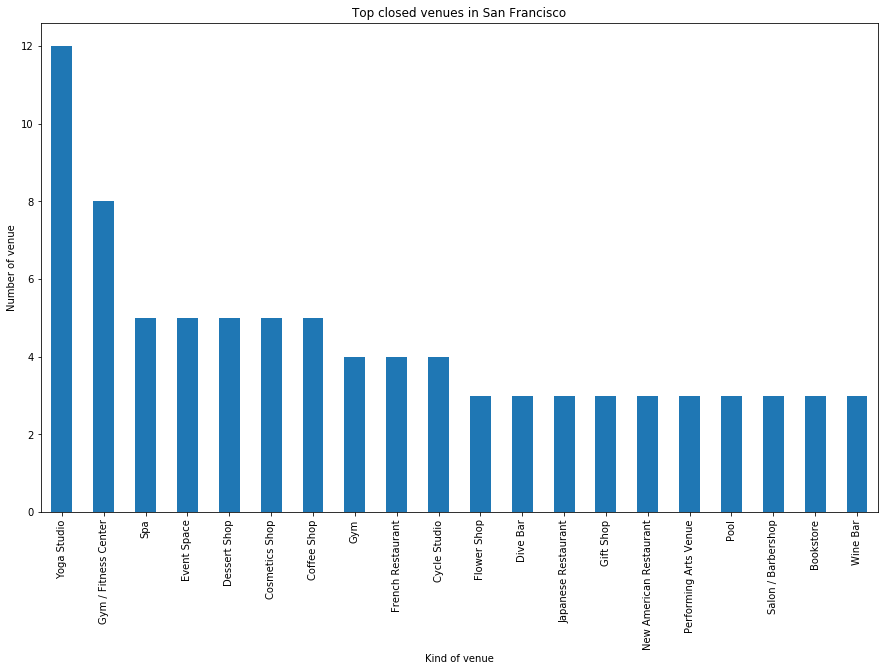

In [610]:
group1_close = group1_close[group1_close['Sum']>2]
group1_close['Sum'].plot(kind='bar', figsize=(15, 9))

plt.xlabel('Kind of venue') # add to x-label to the plot
plt.ylabel('Number of venue') # add y-label to the plot
plt.title('Top closed venues in San Francisco') # add title to the plot

plt.show()

<h2>Discussion</h2>
<b>Certainly, for fuller and more accurate analysis I had to have more data. I mean, I had to got more venues. The best way is have all venues for city. Also, I could more accurate grab data from web. For example, checking merchant not for only one field "Temporary closed" and for another field as "Permanently closed".

Additionally, I could divide each available neighborhood for smaller parts</b>




<h2>Conclusion</h2>
<b>Definitely for this data set I can make accurate conclusion. A lot of business still have problems, someone more, someone less. The main group of venue with greater consequences is sport-venues as fitness and yoga centers, gyms. I can not highlight some borough, problems spread thru all city and does not depend for location.

Thanks for your attention.</b>